In [1]:
import dash
import dash_table
import dash_html_components as html
import dash_core_components as dcc
import plotly.graph_objects as go
import plotly.express as px
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  after removing the cwd from sys.path.


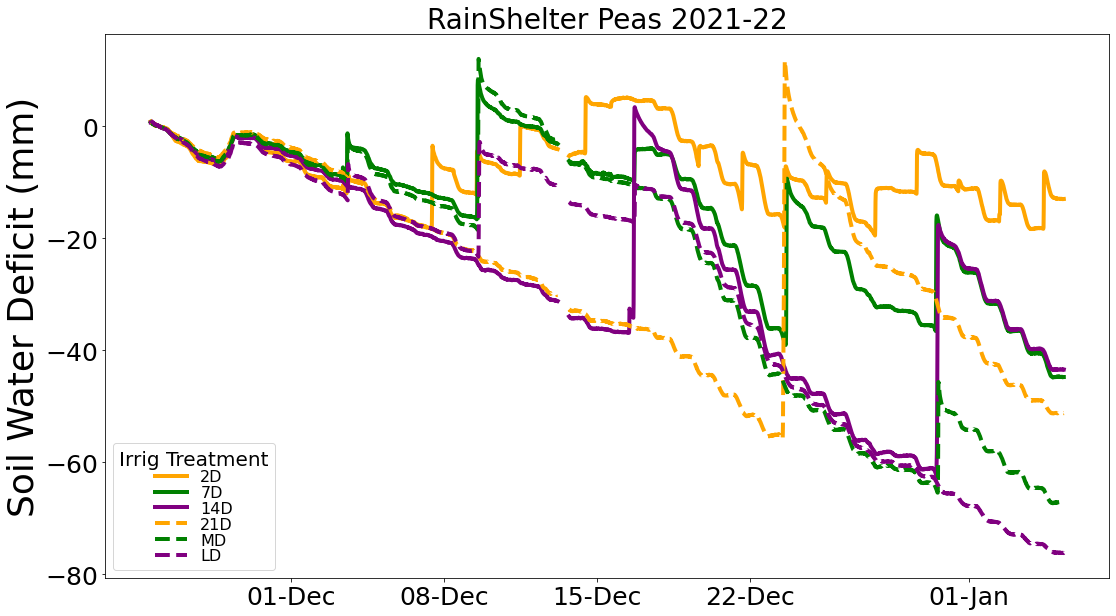

In [2]:
def UpdateSWDGraphData():
    #Read in data
    AllData=pd.read_csv('I:/Science Projects/I211007-02/Exception Files/04 Research/LoggedData/RainShelterAlpha_CS650.dat', #specify file path for data to read in
                             parse_dates=True, #tell the function to parse date columns to datetime formats
                             dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                             skiprows = [0,2,3], #leave out rows 1, 3 and 4 which have redundant information
                             index_col = 0, #Use the first column, which is Date, as an index
                             na_values = 'NAN')

    #Bring in index data
    AllDataIndex=pd.read_csv('I:/Science Projects/I211007-02/Exception Files/04 Research/LoggedData/SoilWaterAndTempIndex.csv',
                             index_col = 0)
    AllDataIndex.loc[:,'Irrigation'] = pd.Categorical(AllDataIndex.loc[:,'Irrigation'],['date','2D','7D','14D','21D','MD','LD'])
    #Apply indexes to data
    AllDataTransposed = AllData.transpose()

    AllDataIndexed = pd.concat([AllDataIndex,AllDataTransposed], axis=1,sort=False)
    AllDataIndexed.index.name='ColumnHeader'
    AllDataIndexed.set_index(['Measurement','Depth','Irrigation','Species','Plot','Sensor', 'MUX', 'Port','Units','Summary','Block','Treatment'], 
                            append=False, inplace=True)
    AllDataIndexed.sort_index(inplace=True)
    Data=AllDataIndexed.transpose()
    Data.index = pd.to_datetime(Data.index)  ## for some reason the concat function changes the data type on the date indes so need to change it back
    Data.columns = Data.columns.droplevel(level=[4,5,6,7,8,9,11]).reorder_levels(['Measurement', 'Depth', 'Irrigation', 'Species', 'Block'])

    ObsData =  Data.VolumetricWaterContent.copy()
    ObsData.sort_index(axis=0,inplace=True)
    ObsData.sort_index(axis=1,inplace=True)

    #Set up factorLevel descriptors
    Depths = ObsData.columns.get_level_values(0).drop_duplicates().values
    F1 = ObsData.columns.get_level_values(1).drop_duplicates().values
    F2 = ObsData.columns.get_level_values(2).drop_duplicates().values
    Blocks = ObsData.columns.get_level_values(3).drop_duplicates().values
    ObsData.loc['2021-12-13 05:00:00':'2021-12-13 17:00:00',:] =np.nan

    #Calculate treatment means omitting data prior to 2014-11-05 08:00:00 to avoid NaN values
    DataMeans =  ObsData.groupby(level=['Depth','Irrigation'],axis=1).mean()

    #Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
    #depth and summing.  The 0-15 layers are divided by 2 to average the two readings
    ProfileWater = DataMeans.loc[:,'D1I'] * 150/2 + \
                   DataMeans.loc[:,'D1B'] * 150/2 + \
                   DataMeans.loc[:,'D2'] * 150 + \
                   DataMeans.loc[:,'D3'] * 300 + \
                   DataMeans.loc[:,'D4'] * 300 + \
                   DataMeans.loc[:,'D5'] * 300 + \
                   DataMeans.loc[:,'D6'] * 300 + \
                   DataMeans.loc[:,'D7'] * 300

    FieldCapacity = ProfileWater.resample('D').max()
    FieldCapacity = FieldCapacity.loc['2021-11-25']   # I would have though this would return a data frame with a single row but instead it returns a series with a multiindex in columns
    SoilWaterDeficit = -(FieldCapacity - ProfileWater.loc['2021-11-18':,:])
    SoilWaterDeficit.loc[:,'date'] = SoilWaterDeficit.index.get_level_values(0)
    return SoilWaterDeficit


  # This calculation only works because field capacity is a multi index series
SoilWaterDeficit = UpdateSWDGraphData()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
cols = ['orange','green','purple','orange','green','purple']
lins = ['-','-','-','--','--','--']
pos = 0
for p in ['2D','7D','14D','21D','MD','LD']:
    plt.plot(SoilWaterDeficit.loc[:,p],lins[pos],color=cols[pos],lw=4,label=p)
    pos+=1
plt.ylabel('Soil Water Deficit (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Peas 2021-22', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Irrig Treatment')
ledg.get_title().set_fontsize(20)

In [3]:
fail here.  The cell after this one is reproducing the same graph as dash but doing it 
locally with matplotlib.  Use for testing underlying data processing.

SyntaxError: invalid syntax (<ipython-input-3-6b4bdb798738>, line 1)

In [ ]:
app = dash.Dash()   #initialising dash app

def SWDGraph():
    SWD = UpdateSWDGraphData()
    # Function for creating line chart showing Google stock prices over time 
    fig = go.Figure([go.Scatter(x =  SWD['date'], y = SWD['2D'],line = dict(dash='solid',color = 'orange', width = 4), name = '2 Day'),
                     go.Scatter(x =  SWD['date'], y = SWD['7D'],line = dict(dash='solid',color = 'green', width = 4), name = '7 Day'),
                    go.Scatter(x =  SWD['date'], y = SWD['14D'],line = dict(dash='solid',color = 'purple', width = 4), name = '14 Day'),
                     go.Scatter(x =  SWD['date'], y = SWD['21D'],line = dict(dash='dash',color = 'orange', width = 4), name = '21 Day'),
                    go.Scatter(x =  SWD['date'], y = SWD['MD'],line = dict(dash='dash',color = 'green', width = 4), name = 'Mid Drought'),
                     go.Scatter(x =  SWD['date'], y = SWD['LD'],line = dict(dash='dash',color = 'purple', width = 4), name = 'Late Drought')])
    fig.update_layout(title = 'Soil Water Deficit (mm)',
                      xaxis_title = 'Date',
                      yaxis_title = 'Soil Water Deficit (mm)',
                       autosize=False,
                      width=1000,
                      height=700,
                      margin=dict(
                        l=50,
                        r=50,
                        b=100,
                        t=100,
                        pad=4
                        ),
                      paper_bgcolor="LightSteelBlue"
                      )
    return html.Div(id = 'parent', children = [
           html.H1(id = 'H1', children = 'Rain shelter Peas 2021/22', style = {'textAlign':'center','marginTop':40,'marginBottom':40}),        
           dcc.Graph(id = 'line_plot', figure = fig)])
 
app.layout = SWDGraph

In [ ]:
if __name__ == '__main__': 
    app.run_server()